In [2]:
import os
import re
import gc
import numpy as np
import collections
from PIL import Image
from textwrap import wrap
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tqdm import tqdm_notebook as tqdm

from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.image import load_img, img_to_array

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, LSTM, add

Using TensorFlow backend.


In [3]:
def clean_description(desc, stopwords):

  cleaned = desc.lower()
  cleaned = re.sub('[^a-z]',' ',cleaned)
  tokens = cleaned.split(' ')
  cleaned = ' '.join([w for w in tokens if w not in stopwords and len(w)>1])
  
  return cleaned

In [4]:
def get_vocabulary(dictionary):
  vocab = set()

  for desc_list in dictionary.values():
    for desc in desc_list:
      words = desc.split(' ')
      for word in words:
        vocab.add(word)

  return vocab

In [5]:
with open('C:\\Users\\Rithwik Datta\\ML\\majorproject\\Flickr8k.token.txt', 'r') as f:
  all_desc = f.read().split('\n')

In [6]:
all_desc[:5]

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .']

In [7]:

stopwords = ['is', 'an', 'a', 'the', 'was']

In [8]:
all_dict = dict()

for desc in all_desc:
  if len(desc) < 1:
    continue
  file_name, file_desc = desc.split('\t')[0].split('.')[0], desc.split('\t')[1]
  
  if file_name not in all_dict.keys():
    all_dict[file_name] = []

  cleaned_desc = clean_description(file_desc, stopwords)
  cleaned_desc = 'startseq ' + cleaned_desc + ' endseq'

  all_dict[file_name].append(cleaned_desc)

In [9]:
vocab = get_vocabulary(all_dict)

In [10]:

print('Total images:', len(all_dict))
print('Total vocabulary without stopwords:', len(vocab))

Total images: 8092
Total vocabulary without stopwords: 8423


In [11]:
!wget https://banner2.cleanpng.com//20181128//vpu//kisspng-cloud-computing-scalable-vector-graphics-joruri-po-5bfe80dc1e3ab9.9777518815434057881238.jpg > //dev//null

The network path was not found.


In [12]:
all_sent_list = [item.strip('startseq').strip('endseq').strip(' ') for sublist in list(all_dict.values()) for item in sublist]


In [13]:
all_sent_len = [len(sent) for sent in all_sent_list]


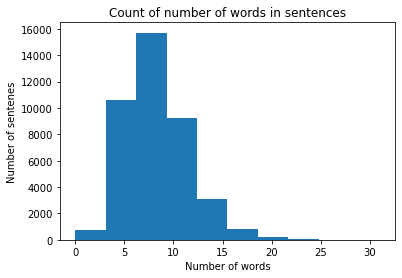

In [14]:
plt.hist([len(sentence.split()) for sentence in all_sent_list])
plt.xlabel('Number of words')
plt.ylabel('Number of sentenes')
plt.title('Count of number of words in sentences')
plt.show()

In [15]:
avg_sent_len = int(np.mean([len(sentence.split()) for sentence in all_sent_list]))
avg_sent_len

8

In [16]:
words = [w for a in all_sent_list for w in a.split(' ')]

In [17]:
counts = collections.Counter(words)
most_common = counts.most_common()
most_common[:15]


[('in', 18987),
 ('on', 10746),
 ('and', 8863),
 ('dog', 8138),
 ('with', 7765),
 ('man', 7275),
 ('of', 6723),
 ('two', 5643),
 ('white', 3959),
 ('black', 3848),
 ('boy', 3581),
 ('are', 3505),
 ('woman', 3403),
 ('girl', 3328),
 ('to', 3176)]

In [18]:

keys = [tupl[0] for tupl in most_common][:15]
values = [tupl[1] for tupl in most_common][:15]

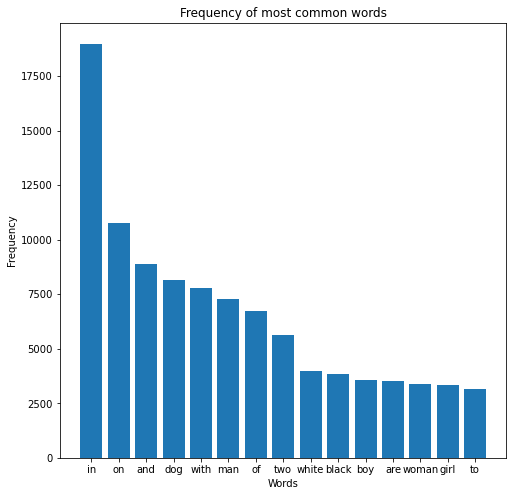

In [19]:
plt.figure(figsize=(8, 8))
plt.bar(keys, values)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of most common words')
plt.show()

In [20]:
lengths = set()
for cap_list in all_dict.values():
  lengths.add(len(cap_list))

print('Number of captions for each image: ', lengths)

Number of captions for each image:  {5}


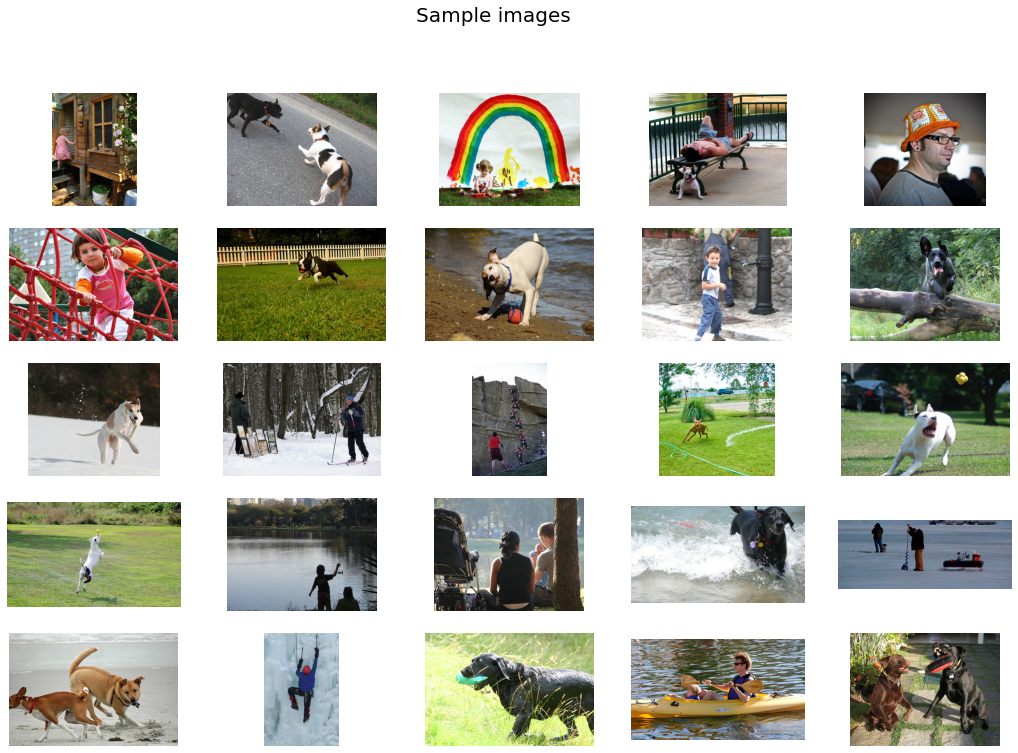

In [21]:
fig = plt.figure()
fig.suptitle('Sample images', fontsize=20)

zoom = 3
w, h = fig.get_size_inches()
fig.set_size_inches(w * zoom, h * zoom)
fig.tight_layout()

for i in range(1, 26):
  ax = fig.add_subplot(5, 5, i)
  ax.imshow(plt.imread('Images/'+list(all_dict.keys())[i-1]+'.jpg'))
  plt.axis('off')

plt.show()

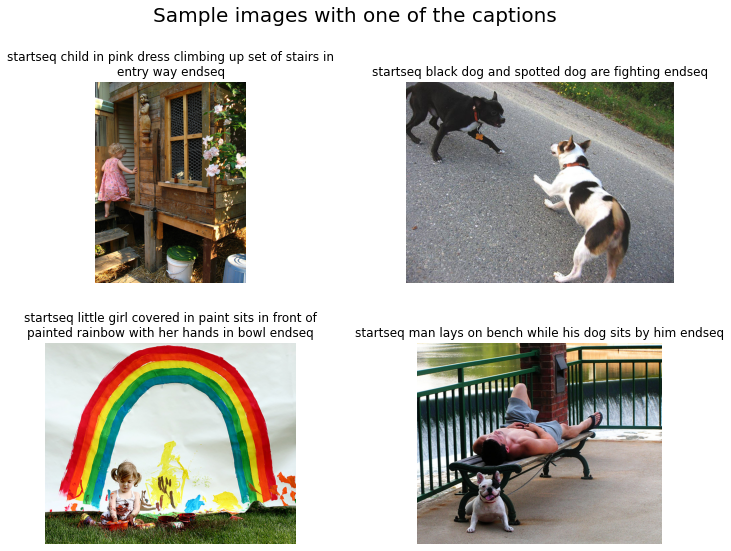

In [22]:
fig = plt.figure()
fig.suptitle('Sample images with one of the captions', fontsize=20)

zoom = 2
w, h = fig.get_size_inches()
fig.set_size_inches(w * zoom, h * zoom)

for i in range(1, 5):
  ax = fig.add_subplot(2, 2, i)
  ax.imshow(plt.imread('Images/'+list(all_dict.keys())[i-1]+'.jpg'))
  title = ax.set_title('\n'.join(wrap(all_dict.get(list(all_dict.keys())[i-1])[0], 60)))
  fig.tight_layout(h_pad=2)
  title.set_y(1.05)
  plt.axis('off')
  fig.subplots_adjust(top=0.85, hspace=0.3)

plt.show()


In [23]:
xcep = Xception(include_top=False, pooling='avg')

In [24]:
predictions = dict()

for dirpath, dirname, files in os.walk('Images'):
  for filename in tqdm(files):
    img_path = os.path.join(dirpath, filename)
    if os.path.isfile(img_path):
      img = Image.open(img_path)
      img = img.resize((299,299))
      img = np.expand_dims(img, axis=0)
      img = img/127.5
      img = img - 1.0

      predictions[filename.split('.')[0]] = xcep.predict(img)

C:\Users\Rithwik\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [25]:
print('Number of extracted features:', len(predictions.get(list(predictions.keys())[0])[0]))

Number of extracted features: 2048


In [27]:
predictions.get(list(predictions.keys())[0])

array([[0.47340968, 0.01730898, 0.07334232, ..., 0.08557959, 0.02102299,
        0.23765522]], dtype=float32)

In [28]:
def create_list(dictionary):
  final_list = []

  for desc_list in dictionary.values():
    for desc in desc_list:
      final_list.append(desc)

  return final_list

In [29]:
def fit_tokenizer(dictionary):
  desc_list = create_list(dictionary)
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(desc_list)
  return tokenizer

In [30]:
def convert_to_input(tokens, pos, im_name, max_len, vocab_len, tokenizer, img_predictions):

  inp = tokens[:pos]
  out = tokens[pos]
  inp = pad_sequences(sequences=[inp], maxlen=max_len)[0]
  out = to_categorical(y=[out], num_classes=vocab_len, dtype='bool')[0]
  
  return img_predictions.get(im_name)[0], inp, out

In [31]:
def convert_all_to_input(dictionary, max_len, vocab_len, tokenizer, img_predictions):
  
  X_1 = list()
  X_2 = list()
  y = list()

  for im_name, descriptions in tqdm(dictionary.items()):
    if im_name in img_predictions.keys():
      for desc in descriptions:
          tokens = tokenizer.texts_to_sequences([desc])[0]
          for i in range(1, len(tokens)):
              _X_1, _X_2, _y = convert_to_input(tokens, i, im_name, max_len, vocab_len, tokenizer, img_predictions)
              X_1.append(_X_1)
              X_2.append(_X_2)
              y.append(_y)
  return np.array(X_1), np.array(X_2), np.array(y)

In [32]:
tokenizer = fit_tokenizer(all_dict)

In [33]:
vocab_len = len(tokenizer.index_word) + 1
vocab_len

8423

In [34]:
max_len = len(max(create_list(all_dict)))
max_len

93

In [35]:
cnn_len = predictions[list(predictions.keys())[0]].shape[1]
cnn_len

2048

In [36]:
X_1, X_2, y = convert_all_to_input(all_dict, max_len, vocab_len, tokenizer, predictions)

C:\Users\Rithwik\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [37]:
def shuffle_arrays(arrays, set_seed=-1):
    """Shuffles arrays in-place, in the same order, along axis=0

    Parameters:
    -----------
    arrays : List of NumPy arrays.
    set_seed : Seed value if int >= 0, else seed is random.
    """
    assert all(len(arr) == len(arrays[0]) for arr in arrays)
    seed = np.random.randint(0, 2**(32 - 1) - 1) if set_seed < 0 else set_seed

    for arr in arrays:
        rstate = np.random.RandomState(seed)
        rstate.shuffle(arr)

In [38]:
shuffle_arrays([X_1, X_2, y])

In [39]:
def create_model(cnn_len, max_len, vocab_len):
  cnn_in = Input(shape=(cnn_len,))
  cnn_x = Dropout(0.5)(cnn_in)
  cnn_out = Dense(units=256, activation='relu')(cnn_x)

  lstm_in = Input(shape=(max_len,))
  lstm_x = Embedding(vocab_len, 256, mask_zero=True)(lstm_in)
  lstm_x = Dropout(0.5)(lstm_x)
  lstm_out = LSTM(256)(lstm_x)

  combined = add([cnn_out, lstm_out])
  combined_x = Dense(units=256, activation='relu')(combined)
  output = Dense(units=vocab_len, activation='softmax')(combined_x)

  model = Model(inputs=[cnn_in, lstm_in], outputs=output)

  return model

In [40]:
model = create_model(cnn_len, max_len, vocab_len)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
            loss=tf.keras.losses.categorical_crossentropy, 
            metrics=[tf.keras.metrics.categorical_accuracy])

In [41]:
batch_size=4096

for i in tqdm(range(0, len(X_1), batch_size)):
  model.fit(x=[X_1[i:i+batch_size], X_2[i:i+batch_size]], y=y[i:i+batch_size], epochs=2, batch_size=256)

C:\Users\Rithwik\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 4096 samples
Epoch 1/2
4096/4096 [==============================] - 107s 26ms/sample - loss: 7.5301 - categorical_accuracy: 0.0793
Epoch 2/2
4096/4096 [==============================] - 31s 8ms/sample - loss: 5.8737 - categorical_accuracy: 0.0962
Train on 4096 samples
Epoch 1/2
4096/4096 [==============================] - 31s 8ms/sample - loss: 6.2589 - categorical_accuracy: 0.1086
Epoch 2/2
4096/4096 [==============================] - 31s 8ms/sample - loss: 5.7424 - categorical_accuracy: 0.1255
Train on 4096 samples
Epoch 1/2
4096/4096 [==============================] - 32s 8ms/sample - loss: 6.0224 - categorical_accuracy: 0.1245
Epoch 2/2
4096/4096 [==============================] - 30s 7ms/sample - loss: 5.5365 - categorical_accuracy: 0.1370
Train on 4096 samples
Epoch 1/2
4096/4096 [==============================] - 30s 7ms/sample - loss: 5.7359 - categorical_accuracy: 0.1450
Epoch 2/2
4096/4096 [==============================] - 30s 7ms/sample - loss: 5.2950 - categorical

4096/4096 [==============================] - 39s 10ms/sample - loss: 3.9159 - categorical_accuracy: 0.2864
Epoch 2/2
4096/4096 [==============================] - 33s 8ms/sample - loss: 3.5693 - categorical_accuracy: 0.3071
Train on 4096 samples
Epoch 1/2
4096/4096 [==============================] - 44s 11ms/sample - loss: 3.8703 - categorical_accuracy: 0.2844
Epoch 2/2
4096/4096 [==============================] - 37s 9ms/sample - loss: 3.5347 - categorical_accuracy: 0.3115
Train on 4096 samples
Epoch 1/2
4096/4096 [==============================] - 39s 10ms/sample - loss: 3.8589 - categorical_accuracy: 0.2839
Epoch 2/2
4096/4096 [==============================] - 34s 8ms/sample - loss: 3.5221 - categorical_accuracy: 0.3135
Train on 4096 samples
Epoch 1/2
4096/4096 [==============================] - 41s 10ms/sample - loss: 3.7679 - categorical_accuracy: 0.3015
Epoch 2/2
4096/4096 [==============================] - 35s 9ms/sample - loss: 3.4201 - categorical_accuracy: 0.3264
Train on 409

In [42]:
def word_for_id(integer, tokenizer):

	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	
	return None

In [43]:
def generate_desc(model, tokenizer, photo, max_len):
	
	start_text = 'startseq'

	for i in range(max_len):

		tokens = tokenizer.texts_to_sequences([start_text])[0]

		tokens = pad_sequences([tokens], maxlen=max_len)

		pred = model.predict([photo, tokens], verbose=0)

		pred = np.argmax(pred)

		word = word_for_id(pred, tokenizer)

		if word is None:
			break

		start_text += ' ' + word

		if word == 'endseq':
			break

	return start_text

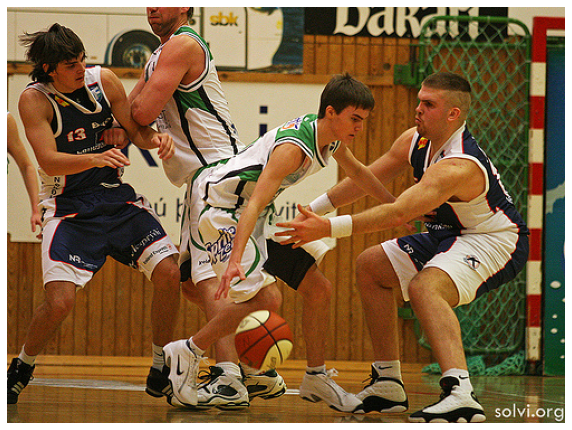

8423
 basketball player in white uniform and white uniform jumps 


In [53]:
img_path = 'E:\\ML subject\\basketball.png'
img = Image.open(img_path)
img2 = img.copy()
img = img.resize((299,299))
img = np.expand_dims(img, axis=0)
img = img/127.5
img = img - 1.0
pred = xcep.predict(img)

plt.figure(figsize=(10, 10))
plt.imshow(img2)
plt.axis('off')
plt.show()

caption = generate_desc(model, tokenizer, pred, 93)
caption = caption.strip('startseq').strip('endseq')
print(caption)

In [47]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 93)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 93, 256)      2156288     input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
______________________________________________________________________________________________

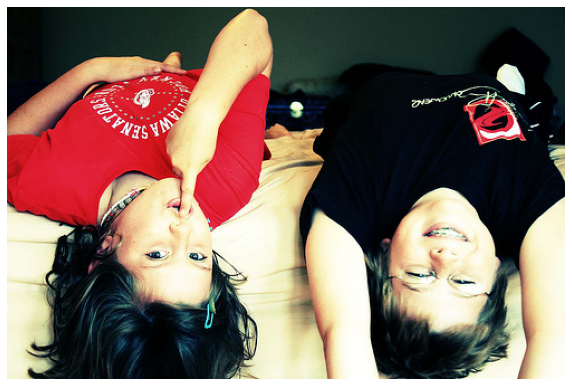

 two young girls are posing for picture 


In [59]:
img_path = 'E:\\ML subject\\test1.jpeg'
img = Image.open(img_path)
img2 = img.copy()
img = img.resize((299,299))
img = np.expand_dims(img, axis=0)
img = img/127.5
img = img - 1.0
pred = xcep.predict(img)

plt.figure(figsize=(10, 10))
plt.imshow(img2)
plt.axis('off')
plt.show()

caption = generate_desc(model, tokenizer, pred, 93)
caption = caption.strip('startseq').strip('endseq')
print(caption)

In [62]:
from gtts import gTTS 
import os

In [64]:
text=caption
language='en'

In [65]:
speech = gTTS(text = text, lang = language, slow = False)

In [67]:
speech.save("text.mp3")

In [71]:
from IPython.display import HTML

In [72]:
json_file = model.to_json()
with open(json_file_path, "w") as file:
   file.write(json_file)

NameError: name 'json_file_path' is not defined

In [76]:
from tensorflow.keras.models import load_model
loaded_model = load_model("network.h5",compile=False)

In [2]:
X_1, X_2, y

NameError: name 'X_1' is not defined

In [ ]:
%store -r X_1